<a href="https://colab.research.google.com/github/Rayonil/Geo_Spatial/blob/main/Geo_Spatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing the required libraries and setting up the figure parameters
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from sklearn.model_selection import KFold
from matplotlib import rcParams

In [ ]:
import lightgbm as lgb

In [ ]:
trips_df = pd.read_csv('../Geo_Spatial/input/trip.csv')
stations_df = pd.read_csv('../Geo_Spatial/input/station.csv')

In [ ]:
stations_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [ ]:
stations_df.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [ ]:
stations_df["lat"] = stations_df["lat"].apply(lambda x:str(x))
stations_df["long"] = stations_df["long"].apply(lambda x:str(x))

In [ ]:
stations_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.8932,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [ ]:
# Criar o mapa da região
m = folium.Map(location=[float(stations_df.lat.median()), float(stations_df.long.median())],
               zoom_start=10, control_scale=True,
               width='100%', height='100%')

# Adicionar os marcadores ao mapa da região
for index, row in stations_df.iterrows():
    folium.Marker([float(row['lat']), float(row['long'])], popup=row['name']).add_to(m)

# Exibir o mapa
m

In [ ]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [ ]:
trips_df['start_date'] = pd.to_datetime(trips_df['start_date'])
trips_df['end_date'] = pd.to_datetime(trips_df['end_date'])

In [ ]:
start_station_info = stations_df[["id","lat","long"]]
start_station_info.columns = ["start_station_id","start_lat","start_long"]
end_station_info = stations_df[["id","lat","long"]]
end_station_info.columns = ["end_station_id","end_lat","end_long"]
trips_df = trips_df.merge(start_station_info,on="start_station_id")
trips_df = trips_df.merge(end_station_info,on="end_station_id")

In [ ]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_lat,start_long,end_lat,end_long
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,37.774814,-122.418954,37.774814,-122.418954
1,4760,113,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103,37.774814,-122.418954,37.774814,-122.418954
2,5070,168,2013-08-29 21:43:00,South Van Ness at Market,66,2013-08-29 21:46:00,South Van Ness at Market,66,598,Subscriber,94115,37.774814,-122.418954,37.774814,-122.418954
3,4584,262,2013-08-29 14:17:00,South Van Ness at Market,66,2013-08-29 14:21:00,South Van Ness at Market,66,587,Subscriber,94612,37.774814,-122.418954,37.774814,-122.418954
4,4079,995,2013-08-29 09:35:00,South Van Ness at Market,66,2013-08-29 09:52:00,South Van Ness at Market,66,327,Subscriber,94102,37.774814,-122.418954,37.774814,-122.418954


In [ ]:
plot_dict = dict()
for index,row in trips_df.iterrows():
    start_lat = row['start_lat']
    start_long = row['start_long']
    end_lat = row['end_lat']
    end_long = row['end_long']
    key = str(start_lat)+'_'+str(start_long)+'_'+str(end_lat)+'_'+str(end_long)
    if key in plot_dict:
        plot_dict[key] += 1
    else:
        plot_dict[key] = 1

In [ ]:
start_lat = []
start_long = []
end_lat = []
end_long = []
nb_trips = []
for key,value in plot_dict.items():
    start_lat.append(float(key.split('_')[0]))
    start_long.append(float(key.split('_')[1]))
    end_lat.append(float(key.split('_')[2]))
    end_long.append(float(key.split('_')[3]))
    nb_trips.append(int(value))

In [ ]:
temp_df = pd.DataFrame({"start_lat":start_lat,"start_long":start_long,"end_lat":end_lat,"end_long":end_long,"nb_trips":nb_trips})

In [ ]:
temp_df.dtypes

start_lat     float64
start_long    float64
end_lat       float64
end_long      float64
nb_trips        int64
dtype: object

<Axes: >

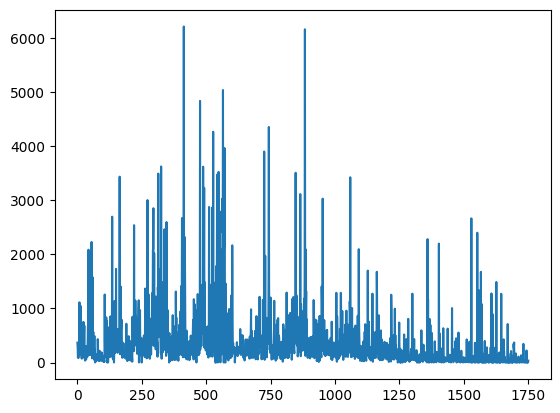

In [ ]:
temp_df.nb_trips.plot()

In [ ]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   start_lat   1751 non-null   float64
 1   start_long  1751 non-null   float64
 2   end_lat     1751 non-null   float64
 3   end_long    1751 non-null   float64
 4   nb_trips    1751 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 68.5 KB


In [ ]:
temp_df.head()

,start_lat,start_long,end_lat,end_long,nb_trips
0,37.774814,-122.418954,37.774814,-122.418954,368
1,37.781332,-122.418603,37.774814,-122.418954,297
2,37.790302,-122.390637,37.774814,-122.418954,97
3,37.782259,-122.392738,37.774814,-122.418954,142
4,37.795001,-122.399970,37.774814,-122.418954,83


In [ ]:
ave_lat = (temp_df.start_lat.median()+temp_df.end_lat.median())/2
ave_lon = (temp_df.start_long.median()+temp_df.end_long.median())/2
directions_map = folium.Map(location=[ave_lat, ave_lon], zoom_start=15)

In [ ]:
for index,row in temp_df.iterrows():
    points = []
    points.append(tuple([row['start_lat'],row['start_long']]))
    points.append(tuple([row['end_lat'],row['end_long']]))
    folium.PolyLine(points,color='red',weight=row['nb_trips']/1000).add_to(directions_map)

In [ ]:
for index,row in stations_df.iterrows():
    folium.Marker([float(row['lat']),float(row['long'])],popup=row['name']).add_to(directions_map)


In [ ]:
directions_map

<ipython-input-34-e876d12d1c01>:10: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bin_edges = np.histogram(trip_dur, range(0,45,1), normed=True)


Text(0, 0.5, 'Cumulative Proportion of Trips')

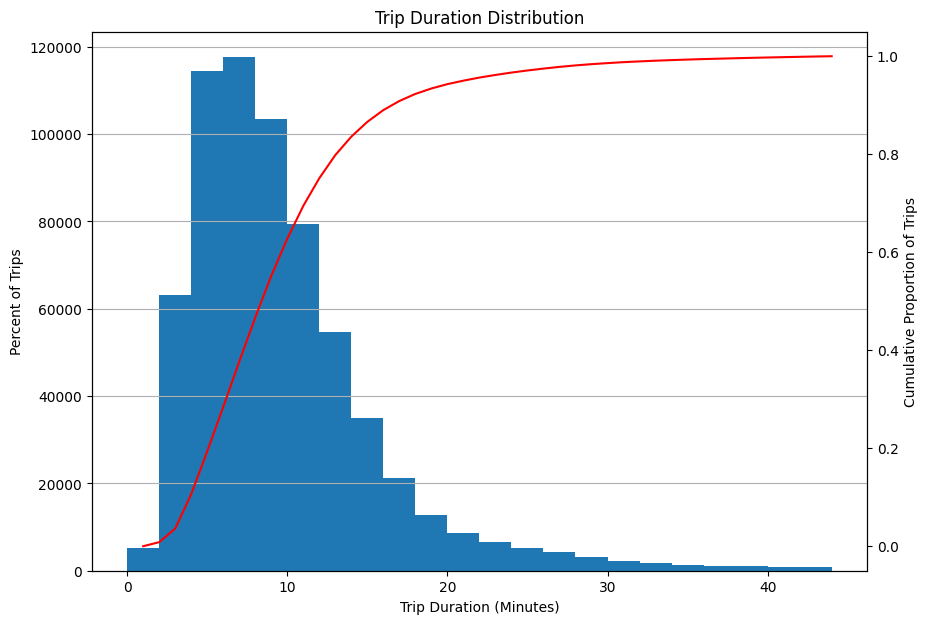

<Figure size 1500x1200 with 0 Axes>

In [ ]:
fig, ax1 = plt.subplots(figsize = (10,7))
ax1.grid(zorder=1)
ax1.xaxis.grid(False)
trip_dur = trips_df['duration'].values/60
plt.hist(trip_dur, bins = range(0,45,2),zorder=0)
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Percent of Trips')
plt.title('Trip Duration Distribution')
plt.figure(figsize=(15,12))
hist, bin_edges = np.histogram(trip_dur, range(0,45,1), normed=True)
cum_trip_dur = np.cumsum(hist)
ax2 = ax1.twinx()
ax2.plot(range(1,45,1),cum_trip_dur,c='red')
ax2.set_ylabel('Cumulative Proportion of Trips')

In [ ]:
trips_df.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_lat,start_long,end_lat,end_long
0,4576,63,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,37.774814,-122.418954,37.774814,-122.418954
1,4760,113,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103,37.774814,-122.418954,37.774814,-122.418954
2,5070,168,2013-08-29 21:43:00,South Van Ness at Market,66,2013-08-29 21:46:00,South Van Ness at Market,66,598,Subscriber,94115,37.774814,-122.418954,37.774814,-122.418954
3,4584,262,2013-08-29 14:17:00,South Van Ness at Market,66,2013-08-29 14:21:00,South Van Ness at Market,66,587,Subscriber,94612,37.774814,-122.418954,37.774814,-122.418954
4,4079,995,2013-08-29 09:35:00,South Van Ness at Market,66,2013-08-29 09:52:00,South Van Ness at Market,66,327,Subscriber,94102,37.774814,-122.418954,37.774814,-122.418954


In [ ]:
trips_df['week']=trips_df.start_date.dt.dayofweek
trips_df['start_hour'] = trips_df.start_date.dt.hour
trips_df['start_day'] = trips_df.start_date.dt.day
trips_df['end_hour'] = trips_df.end_date.dt.hour
trips_df['end_day'] = trips_df.end_date.dt.day

Text(0.5, 1.0, 'Trip Duration Distribution Over Time of Day (Week Days)')

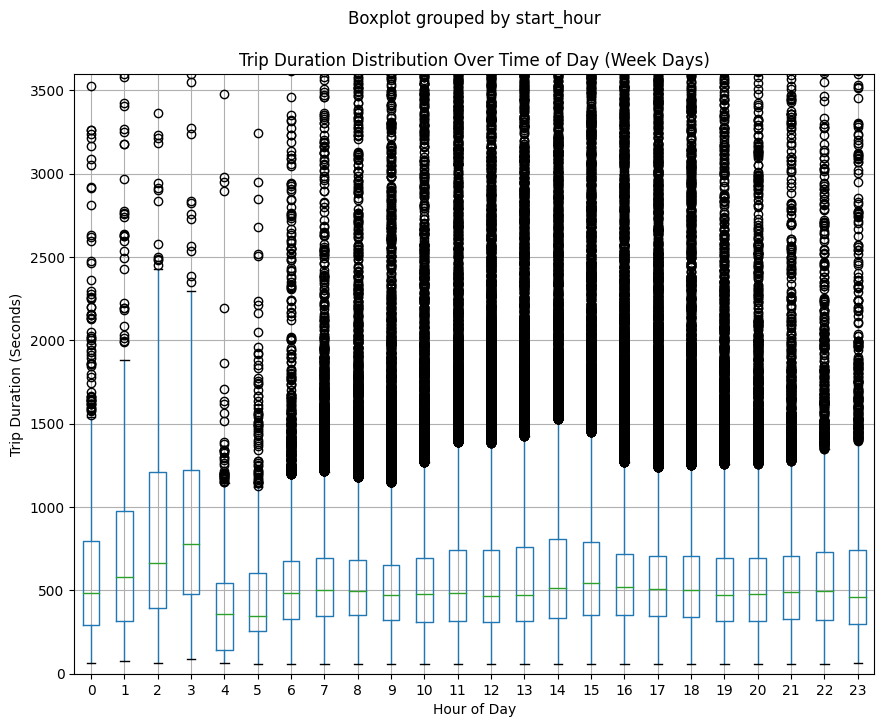

In [ ]:
weekdaytrips_df = trips_df.loc[(trips_df.duration <= 7200) & (trips_df.week <5)]
weekdaytrips_df.boxplot(column="duration",by="start_hour",figsize=(10,8))
plt.ylim(0,3600)
plt.ylabel('Trip Duration (Seconds)')
plt.xlabel('Hour of Day')
plt.title('Trip Duration Distribution Over Time of Day (Week Days)')

Text(0.5, 1.0, 'Trip Duration Distribution Over Time of Day (Weekend days)')

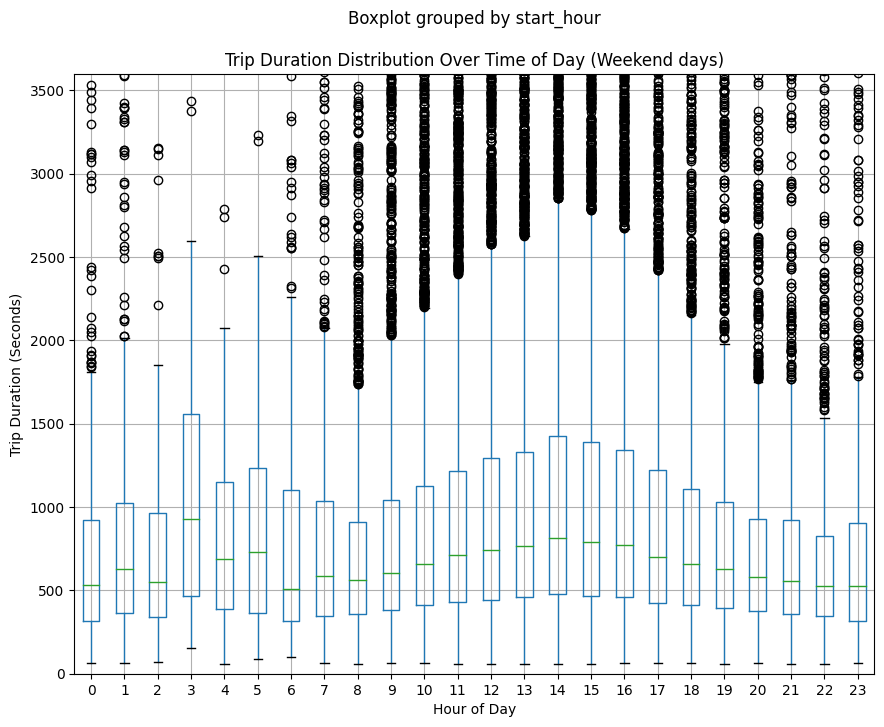

In [ ]:
weekendtrips_df = trips_df.loc[(trips_df.duration <= 7200) & (trips_df.week >4)]
weekendtrips_df.boxplot(column="duration",by="start_hour",figsize=(10,8))
plt.ylim(0,3600)
plt.ylabel('Trip Duration (Seconds)')
plt.xlabel('Hour of Day')
plt.title('Trip Duration Distribution Over Time of Day (Weekend days)')